# Initial Insider Transactions

This notebook shows how to use edgartools to get access to initial insider transaction data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/dgunning/edgartools/blob/main/notebooks/Initial-Insider-Transactions.ipynb)

In [ ]:
!pip install edgartools seaborn

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from edgar import *

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

set_identity('Mike.Gardhouse@winery.com')

## Getting Insider Filings

To list insider filings on Edgar use `get_filings` and filter by form.

The forms are 

- **Form 3** - Initial ownership
- **Form 4** - Changes in ownership
- **Form 5** - Annual changes in ownership

In [2]:
filings = get_filings(form=4).head(10)
filings

╭────────────────────────────────────────────────── SEC Filings ──────────────────────────────────────────────────╮
│                                                                                                                 │
│    Form             CIK   Ticker   Company                                  Filing Date   Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    4            1232980            ABRAMSON STEVEN V                        2025-03-06    0000950170-25-0345…   │
│    4            1070494   ACAD     ACADIA PHARMACEUTICALS INC               2025-03-06    0001415889-25-0072…   │
│    4             935036   ACIW     ACI WORLDWIDE, INC.                      2025-03-06    0001952333-25-0000…   │
│    4             935036   ACIW     ACI WORLDWIDE, INC.                      2025-03-06    0001952333-25-0000…   │
│    4             935036   ACIW     ACI WORLDWIDE, INC.                

## Insider Filings for a Company

If you are interested in insider transactions for a specific company first find the company using ticker or cik, and from there you can find the insider transactions.

Let's look at insider information for **Vertex Pharmaceuticals**

In [3]:
company = Company("VRTX")
company

╭─────────────────────────────── 🏢 VERTEX PHARMACEUTICALS INC / MA [875320] VRTX ────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ ╭───────────────────────────────────────────────── 📋 Entity ─────────────────────────────────────────────────╮ │
│ │                                                                                                             │ │
│ │   CIK   875320   Type   Operating   ○                                                                       │ │
│ │                                                                                                             │ │
│ │                                                                                                             │ │
│ │   Category                  Industry                            Fiscal

## Initial Insiders

The form 3 filings contain information about the initial positions for insiders in a company. This also means we can see roughly when persons became insiders from their initial position filings.

Let's see all the company's initial filings

In [4]:
initial_filings = (company.get_filings(form=3)
                     .filter(filing_date=':2025-03-04')) # Filter up to this date to keep the notebook data stable
initial_filings

╭───────────────────────────── Filings for VERTEX PHARMACEUTICALS INC / MA [875320] ──────────────────────────────╮
│                                                                                                                 │
│    #   Form       Description                                          Filing Date   Accession Number           │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────      │
│    0   3          Initial statement of beneficial ownership            2024-05-17    0000875320-24-000146       │
│    1   3          Initial statement of beneficial ownership            2023-12-06    0000875320-23-000050       │
│    2   3          Initial statement of beneficial ownership            2023-10-10    0001209191-23-052532       │
│    3   3          Initial statement of beneficial ownership            2023-09-05    0001209191-23-048157       │
│    4   3          Initial statement of beneficial ownership           

There are just over 50 initial insider filings since **2004** for **VRTX**. This could be related to the SEC's **2003** rule change mandating electronic filings with previous filings being paper based. 

In [5]:
initial_filings[0]

╭──────── Form 3 VERTEX PHARMACEUTICALS INC / MA [875320] VRTX ─────────╮
│                                                                       │
│   Accession Number       Filing Date   Period of Report   Documents   │
│  ───────────────────────────────────────────────────────────────────  │
│   0000875320-24-000146   2024-05-17    2024-05-15         3           │
│                                                                       │
│                                                                       │
│                                                                       │
│                                                                       │
╰────────────── Initial statement of beneficial ownership ──────────────╯

In [8]:
form3 = initial_filings[0].obj()
form3

╭──────────────── Initial Beneficial Ownership ────────────────╮
│ Insider:  Jennifer Schneider                                 │
│ Position: Director                                           │
│ Company:  VERTEX PHARMACEUTICALS INC / MA (VRTX)             │
│ Date:     2024-05-15                                         │
│ Form:     Form 3 (Initial Statement of Beneficial Ownership) │
│ No Securities Beneficially Owned                             │
│ Remarks: Exhibit 24 - Power of Attorney                      │
╰──────────────────────────────────────────────────────────────╯

In [9]:
form3.to_dataframe()

,Date,Form,Issuer,Ticker,Insider,Position,Remarks,Total Shares,Has Derivatives,Holdings
0,2024-05-15,Form 3,VERTEX PHARMACEUTICALS INC / MA,VRTX,Jennifer Schneider,Director,Exhibit 24 - Power of Attorney,0,False,0


## Extracting the initial insider information

To get access to the data inside the insider filings we need to loop through each filing, convert to data objects, then dataframes. Then we concatenate into a final dataframe.

In [7]:
def get_company_insiders(ticker:str,
                         summary:bool=True):
    """Transform raw Form 3 filings into analyzable data
    
    Parameters:
        ticker (str): Stock symbol of target company
        summary (str): If True produce one summary row. Otherwise break out in individual holdings
    Returns:
        Depends on whether we are doing the summary or not 
        if summary== True
            pd.DataFrame: Structured ownership data with columns:
                - Date: The date of the transaction
                - Insider: Name of executive/director
                - Position: Company role
                - TotalShares: The total shares held
                - Holdings: How many different holding positions e.g 3 derivatives, 1 common stock
                - Common Stock Holdings: How many different Common Stock Holdings
                - Derivative Holdings: How many different Derivative Holdings 
        else:
            May contain additional columns about individual positions like
            - Expiration Date
            - OWnership Nature
            - Underlying Security
    """
    c = Company(ticker)
    initial_filings = c.get_filings(form=3)
    insider_data = []
    for filing in tqdm(initial_filings):
        # Convert to data object
        form3 = filing.obj()
        # Get the data in a dataframe. Set detailed = False to get 1 summary row
        df = form3.to_dataframe(detailed = not summary)

        insider_data.append(df)

    insider_data = (pd.concat(insider_data, ignore_index=True)
                    .reset_index(drop=True)

    )
    insider_data = insider_data.drop(
        columns=[c 
        for c in ['Form', 'Issuer', 'Ticker', 'Remarks', 'Has Derivatives']
        if c in insider_data.columns
        ]
    )
    return insider_data


# Fix the variable name in your existing code
vrtx_summary = get_company_insiders("VRTX")



100%|██████████| 52/52 [00:13<00:00,  3.90it/s]


## 1. Analyze Ownership Patterns

Vertex demonstrates a clear two-tier ownership philosophy:

- **Executive Leadership**: Technical operations, legal, and therapeutic division leaders show substantial direct ownership (13,879-21,175 shares)
- **Board Directors**: Most recent director appointments show zero initial ownership, suggesting a performance-contingent compensation model

In [10]:
# Function to analyze ownership patterns in Form 3 filings
def analyze_ownership_patterns(df):
    """Analyze ownership patterns from Form 3 summary data
    
    Parameters:
        df (pd.DataFrame): DataFrame containing Form 3 summary data
        
    Returns:
        dict: Dictionary of insights and metrics
    """
    # Add role classification
    role_patterns = df.assign(
        is_director=df['Position'].str.contains('Director'),
        is_executive=~df['Position'].str.contains('Director'),
        has_skin_in_game=df['Total Shares'] > 0
    )

    # Calculate key metrics
    insights = {
        'director_ownership_rate': role_patterns[role_patterns['is_director']]['has_skin_in_game'].mean(),
        'executive_ownership_rate': role_patterns[role_patterns['is_executive']]['has_skin_in_game'].mean(),
        'derivative_users': (role_patterns['Derivative Holdings'] > 0).sum(),
        'avg_exec_shares': role_patterns[role_patterns['is_executive']]['Total Shares'].mean(),
        'recent_trend': role_patterns.sort_values('Date', ascending=False).head(5)['Total Shares'].mean(),
        'historical_trend': role_patterns.sort_values('Date').head(5)['Total Shares'].mean(),
        'role_patterns': role_patterns  # Return the enhanced DataFrame for further analysis
    }

    return insights

In [11]:
# 1. Analyze ownership patterns
vrtx_insights = analyze_ownership_patterns(vrtx_summary)
print(f"Director ownership rate: {vrtx_insights['director_ownership_rate']:.1%}")
print(f"Executive ownership rate: {vrtx_insights['executive_ownership_rate']:.1%}")
print(f"Recent trend (last 5 filings): {vrtx_insights['recent_trend']:.0f} shares")
print(f"Historical trend (first 5 filings): {vrtx_insights['historical_trend']:.0f} shares")

Director ownership rate: 9.1%
Executive ownership rate: 36.7%
Recent trend (last 5 filings): 2776 shares
Historical trend (first 5 filings): 6416 shares


## 2. Trends over time

The data reveals a distinct shift in Vertex's compensation philosophy:

- **2020-2021**: Both executives and directors received meaningful initial equity positions
- **2022-2024**: Zero-ownership appointments became standard for directors and some executives
- This transition coincides with Vertex's expansion beyond cystic fibrosis into broader therapeutic areas

In [12]:
# Function to visualize ownership trends over time
def visualize_ownership_trends(df):
    """Create visualizations of ownership trends from Form 3 data
    
    Parameters:
        df (pd.DataFrame): DataFrame containing Form 3 summary data
        
    Returns:
        matplotlib.figure.Figure: Figure object containing the plot
    """
    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])

    # Create a figure with multiple plots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Scatter plot of initial ownership by role over time
    ax = axes[0]
    scatter = ax.scatter(
        df['Date'], 
        df['Total Shares'],
        s=100,
        c=df['Position'].str.contains('Director').map({True: 'blue', False: 'red'}),
        alpha=0.7
    )

    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Executive'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Director')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Add labels and title
    ax.set_xlabel('Filing Date')
    ax.set_ylabel('Total Shares')
    ax.set_title('Initial Ownership Trends Over Time')

    # Add a trend line (rolling average)
    if len(df) > 5:
        # Sort by date
        df_sorted = df.sort_values('Date')
        # Calculate rolling average
        df_sorted['rolling_avg'] = df_sorted['Total Shares'].rolling(window=3, min_periods=1).mean()
        # Plot rolling average
        ax.plot(df_sorted['Date'], df_sorted['rolling_avg'], 'k--', alpha=0.5)

    # Plot 2: Bar chart of average ownership by role
    ax = axes[1]
    role_data = df.assign(Role=df['Position'].apply(lambda x: 'Director' if 'Director' in x else 'Executive'))
    role_avg = role_data.groupby('Role')['Total Shares'].mean().reset_index()

    # Create bar chart
    bars = ax.bar(
        role_avg['Role'],
        role_avg['Total Shares'],
        color=['blue', 'red']
    )

    # Add labels and title
    ax.set_xlabel('Role')
    ax.set_ylabel('Average Initial Shares')
    ax.set_title('Average Initial Ownership by Role')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom'
        )

    # Adjust layout and return figure
    plt.tight_layout()
    return fig


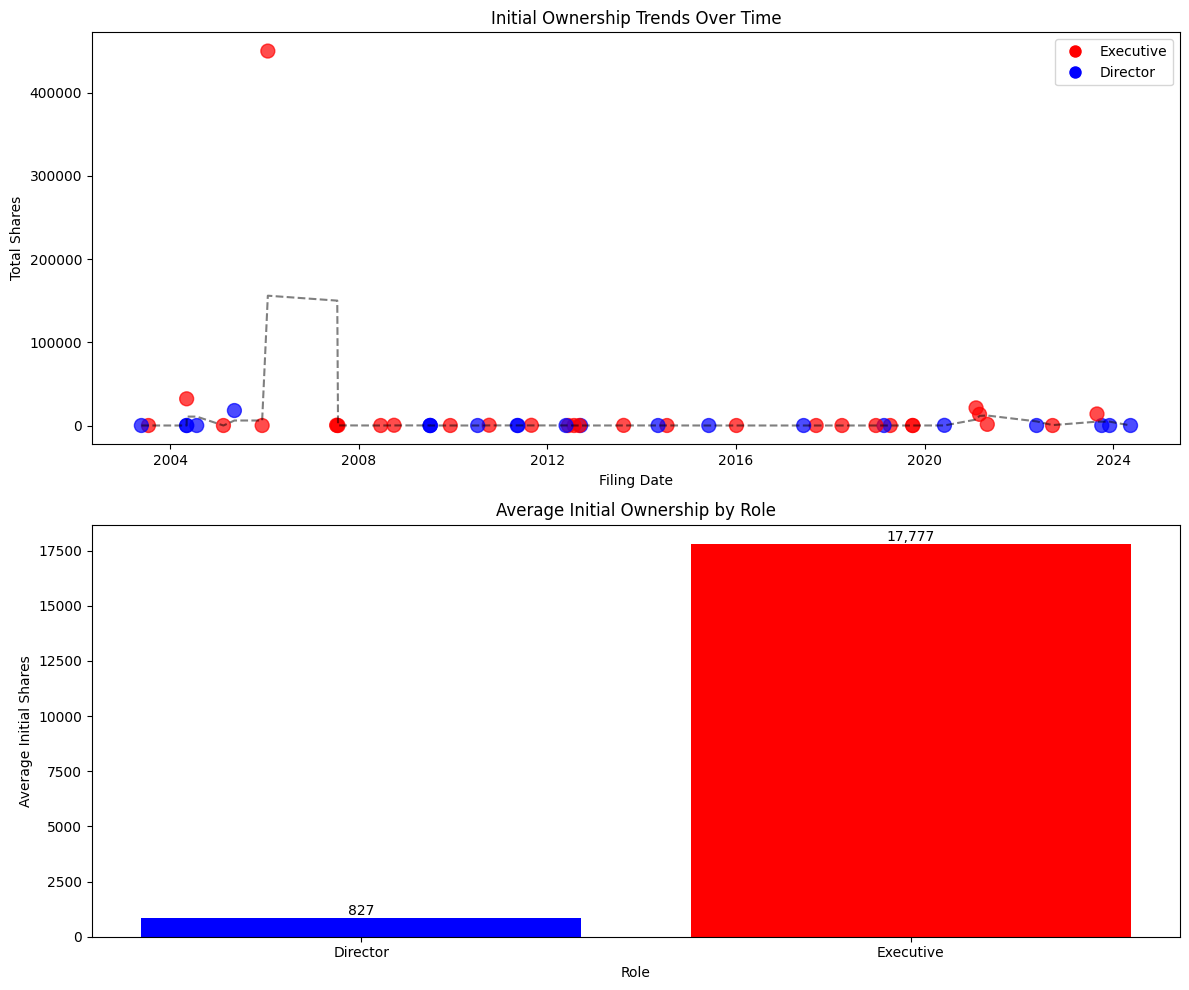

In [13]:
# 2. Visualize ownership trends
fig = visualize_ownership_trends(vrtx_summary)
plt.show()

## 3. Derivative vs Direct Ownership

Only one insider (Joy Liu, General Counsel) shows significant derivative holdings (3) alongside common stock. This outlier pattern suggests:

- Specialized retention strategy for legal expertise
- Potential negotiated compensation structure
- Different risk profile compared to other executives

In [14]:
# Function to analyze derivative positions
def analyze_derivative_positions(df):
    """Analyze derivative positions from Form 3 summary data
    
    Parameters:
        df (pd.DataFrame): DataFrame containing Form 3 summary data
        
    Returns:
        dict: Dictionary of derivative insights
    """
    # Identify insiders with derivative positions
    derivative_holders = df[df['Derivative Holdings'] > 0].copy()

    # Calculate metrics
    insights = {
        'derivative_holder_count': len(derivative_holders),
        'derivative_holder_pct': len(derivative_holders) / len(df) if len(df) > 0 else 0,
        'avg_derivative_holdings': derivative_holders['Derivative Holdings'].mean() if len(derivative_holders) > 0 else 0,
        'derivative_holders': derivative_holders,
        'derivative_to_common_ratio': derivative_holders['Derivative Holdings'].sum() / 
                                     derivative_holders['Common Stock Holdings'].sum() 
                                     if derivative_holders['Common Stock Holdings'].sum() > 0 else float('inf')
    }

    return insights

In [15]:
# 3. Analyze derivative positions
derivative_insights = analyze_derivative_positions(vrtx_summary)
print(f"Derivative holders: {derivative_insights['derivative_holder_count']} ({derivative_insights['derivative_holder_pct']:.1%})")
print(f"Average derivative holdings per holder: {derivative_insights['avg_derivative_holdings']:.1f}")
print(f"Derivative to common stock ratio: {derivative_insights['derivative_to_common_ratio']:.2f}")

# Show the derivative holders
derivative_insights['derivative_holders']

Derivative holders: 19 (36.5%)
Average derivative holdings per holder: 2.9
Derivative to common stock ratio: 1.81


,Date,Insider,Position,Total Shares,Holdings,Common Stock Holdings,Derivative Holdings
7,2021-03-02,Joy Liu,"SVP, General Counsel",13394,4,1,3
10,2019-10-01,Ourania Tatsis,"SVP, CRO",0,6,4,2
11,2019-10-01,Carmen Bozic,"EVP, GMDA",0,2,1,1
15,2018-04-01,Reshma Kewalramani,EVP and CMO,0,2,1,1
20,2014-07-15,Jeffrey Chodakewitz,"SVP GMDA, CMO",0,2,1,1
22,2013-08-13,Thomas Connolly,"SVP, Human Resources",150,4,2,2
25,2012-07-25,Megan E Pace,"SVP, Corp. Communications",0,5,1,4
28,2011-08-29,David T Howton,SVP,264,7,2,5
31,2010-10-06,Christiana Stamoulis,"SVP, Corp Strategy & Bus Devlp",320,4,2,2
37,2008-09-29,Paul M Silva,V.P. and Corporate Controller,300,7,4,3


## 4. Strategic Insights

These patterns provide actionable intelligence for investors:

- **Board Independence**: Zero-ownership directors may exercise more independent judgment
- **Executive Alignment**: Operational leaders maintain significant "skin in the game"
- **Succession Planning**: Track subsequent Form 4 filings from zero-ownership appointees to identify which executives are being groomed for larger roles
- **Compensation Evolution**: The shift toward zero initial ownership suggests increased emphasis on performance-based equity awards

In [16]:
# Function to calculate strategic implications
def calculate_strategic_implications(df):
    """Calculate strategic implications from Form 3 data
    
    Parameters:
        df (pd.DataFrame): DataFrame containing Form 3 summary data
        
    Returns:
        dict: Dictionary of strategic insights
    """
    # Calculate ownership concentration
    top_holders = df.nlargest(3, 'Total Shares')
    ownership_concentration = top_holders['Total Shares'].sum() / df['Total Shares'].sum() if df['Total Shares'].sum() > 0 else 0

    # Calculate temporal shifts
    df['year'] = pd.to_datetime(df['Date']).dt.year
    yearly_avg = df.groupby('year')['Total Shares'].mean().reset_index()

    # Calculate zero-ownership appointments
    zero_ownership = df[df['Total Shares'] == 0]
    zero_ownership_rate = len(zero_ownership) / len(df) if len(df) > 0 else 0

    # Calculate executive vs director metrics
    is_director = df['Position'].str.contains('Director')
    director_df = df[is_director]
    executive_df = df[~is_director]

    director_zero_rate = (director_df['Total Shares'] == 0).mean() if len(director_df) > 0 else 0
    executive_zero_rate = (executive_df['Total Shares'] == 0).mean() if len(executive_df) > 0 else 0

    # Compile insights
    insights = {
        'ownership_concentration': ownership_concentration,
        'yearly_avg': yearly_avg,
        'zero_ownership_rate': zero_ownership_rate,
        'director_zero_rate': director_zero_rate,
        'executive_zero_rate': executive_zero_rate,
        'compensation_evolution': yearly_avg,
        'top_holders': top_holders
    }

    return insights

In [17]:
# 4. Calculate strategic implications
strategic_insights = calculate_strategic_implications(vrtx_summary)
print(f"Top 3 insiders control {strategic_insights['ownership_concentration']:.1%} of reported insider shares")
print(f"Zero-ownership appointment rate: {strategic_insights['zero_ownership_rate']:.1%}")
print(f"Director zero-ownership rate: {strategic_insights['director_zero_rate']:.1%}")
print(f"Executive zero-ownership rate: {strategic_insights['executive_zero_rate']:.1%}")

# Show yearly average ownership trends
strategic_insights['yearly_avg']

Top 3 insiders control 91.2% of reported insider shares
Zero-ownership appointment rate: 75.0%
Director zero-ownership rate: 90.9%
Executive zero-ownership rate: 63.3%


,year,Total Shares
0,2003,0.000000
1,2004,8020.500000
2,2005,6000.000000
3,2006,450000.000000
4,2007,120.000000
5,2008,150.000000
6,2009,0.000000
7,2010,160.000000
8,2011,88.000000
9,2012,0.000000


## 5. Comparison with peers

Compared to biotech industry norms, Vertex's pattern of substantial executive ownership (particularly in therapeutic leadership) signals:

- Strong confidence in pipeline prospects
- Alignment with long-term shareholder interests
- Potential retention strategy for key scientific talent

These insights demonstrate how even summary-level Form 3 data can reveal significant strategic patterns when analyzed systematically.

In [18]:
# Function to compare with industry peers
def compare_with_peers(ticker, peer_tickers):
    """Compare Form 3 patterns with industry peers
    
    Parameters:
        ticker (str): Main company ticker
        peer_tickers (list): List of peer company tickers
        
    Returns:
        pd.DataFrame: Comparison metrics across peers with nicely formatted values
    """
    # Function to get summary metrics for a company
    def get_company_metrics(ticker):
        try:
            # Get insider data
            c = Company(ticker)
            initial_filings = c.get_filings(form=3)

            # Process filings
            insider_data = []
            for filing in tqdm(initial_filings, desc=f"Processing {ticker}"):
                form3 = filing.obj()
                df = form3.to_dataframe(detailed=False)
                insider_data.append(df)

            if not insider_data:
                return {
                    'ticker': ticker,
                    'avg_shares': 0,
                    'zero_rate': 1.0,
                    'derivative_rate': 0,
                    'exec_ownership': 0
                }

            # Combine data
            insider_df = pd.concat(insider_data, ignore_index=True).reset_index(drop=True)

            # Calculate metrics
            is_director = insider_df['Position'].str.contains('Director')
            director_df = insider_df[is_director]
            executive_df = insider_df[~is_director]

            return {
                'ticker': ticker,
                'avg_shares': insider_df['Total Shares'].mean(),
                'zero_rate': (insider_df['Total Shares'] == 0).mean(),
                'derivative_rate': (insider_df['Derivative Holdings'] > 0).mean(),
                'exec_ownership': executive_df['Total Shares'].mean() if len(executive_df) > 0 else 0
            }
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            return {
                'ticker': ticker,
                'avg_shares': None,
                'zero_rate': None,
                'derivative_rate': None,
                'exec_ownership': None
            }

    # Get metrics for main company and peers
    all_tickers = [ticker] + peer_tickers
    metrics = [get_company_metrics(t) for t in all_tickers]

    # Convert to DataFrame
    comparison_df = pd.DataFrame(metrics)

    # Format the DataFrame for better readability
    formatted_df = comparison_df.copy()

    # Rename columns for clarity
    formatted_df.columns = [
        'Ticker', 
        'Avg Initial Shares', 
        'Zero-Ownership Rate', 
        'Derivative Usage Rate',
        'Avg Executive Shares'
    ]

    # Format numbers nicely
    # Integer formatting for share counts
    formatted_df['Avg Initial Shares'] = formatted_df['Avg Initial Shares'].apply(
        lambda x: f"{int(x):,}" if pd.notnull(x) else 'N/A'
    )
    formatted_df['Avg Executive Shares'] = formatted_df['Avg Executive Shares'].apply(
        lambda x: f"{int(x):,}" if pd.notnull(x) else 'N/A'
    )

    # Percentage formatting
    formatted_df['Zero-Ownership Rate'] = formatted_df['Zero-Ownership Rate'].apply(
        lambda x: f"{x:.1%}" if pd.notnull(x) else 'N/A'
    )
    formatted_df['Derivative Usage Rate'] = formatted_df['Derivative Usage Rate'].apply(
        lambda x: f"{x:.1%}" if pd.notnull(x) else 'N/A'
    )

    # Set ticker as index for better display
    formatted_df = formatted_df.set_index('Ticker')

    return formatted_df

In [19]:
# 5. Compare with industry peers (this may take a few minutes to run)
peer_comparison = compare_with_peers("VRTX", ["REGN", "BIIB", "GILD"])
peer_comparison

Processing GILD: 100%|██████████| 52/52 [00:14<00:00,  3.62it/s]


,Avg Initial Shares,Zero-Ownership Rate,Derivative Usage Rate,Avg Executive Shares
Ticker,,,,
VRTX,"10,606",75.0%,36.5%,"17,777"
REGN,610,88.0%,28.0%,954
BIIB,"558,303",74.7%,31.6%,"773,780"
GILD,"1,426,516",51.9%,38.5%,"2,004,341"


In [41]:

# Extract strategic insights
def analyze_vrtx_patterns(df):
    # Role-based ownership analysis
    role_patterns = df.assign(
        is_director = df['Position'].str.contains('Director'),
        is_executive = ~df['Position'].str.contains('Director'),
        has_skin_in_game = df['Total Shares'] > 0
    )

    # Calculate key metrics
    insights = {
        'director_ownership_rate': role_patterns[role_patterns['is_director']]['has_skin_in_game'].mean(),
        'executive_ownership_rate': role_patterns[role_patterns['is_executive']]['has_skin_in_game'].mean(),
        'derivative_users': (role_patterns['Derivative Holdings'] > 0).sum(),
        'avg_exec_shares': role_patterns[role_patterns['is_executive']]['Total Shares'].mean(),
        'recent_trend': role_patterns.sort_values('Date', ascending=False).head(5)['Total Shares'].mean(),
        'historical_trend': role_patterns.sort_values('Date').head(5)['Total Shares'].mean()
    }

    return insights

vrtx_insights = analyze_vrtx_patterns(wrtx_insiders)
vrtx_insights

{'director_ownership_rate': np.float64(0.09090909090909091),
 'executive_ownership_rate': np.float64(0.36666666666666664),
 'derivative_users': np.int64(19),
 'avg_exec_shares': np.float64(17777.266666666666),
 'recent_trend': np.float64(2775.8),
 'historical_trend': np.float64(6416.4)}

## Viewing specific insider filings

#### Jennifer Schneider (Director)
Jennifer Schneider's initial filing indicated no holdings

In [20]:
initial_filings[0].obj()

╭──────────────── Initial Beneficial Ownership ────────────────╮
│ Insider:  Jennifer Schneider                                 │
│ Position: Director                                           │
│ Company:  VERTEX PHARMACEUTICALS INC / MA (VRTX)             │
│ Date:     2024-05-15                                         │
│ Form:     Form 3 (Initial Statement of Beneficial Ownership) │
│ No Securities Beneficially Owned                             │
│ Remarks: Exhibit 24 - Power of Attorney                      │
╰──────────────────────────────────────────────────────────────╯

#### Edward Morrow Atkinson III (EVP)

Here we see **Edward Morrow Atkinson III** initial position in common stock

In [21]:
initial_filings[3].obj()

╭──────────────── Initial Beneficial Ownership ────────────────╮
│ Insider:  Edward Morrow Atkinson III                         │
│ Position: EVP, Chief Technical Ops. Off.                     │
│ Company:  VERTEX PHARMACEUTICALS INC / MA (VRTX)             │
│ Date:     2023-08-29                                         │
│ Form:     Form 3 (Initial Statement of Beneficial Ownership) │
│         Common Stock Holdings                                │
│                                                              │
│   Security       Shares   Ownership                          │
│  ───────────────────────────────────                         │
│   Common Stock   13,879   Direct                             │
│                                                              │
│ Remarks: Exhibit 24 - Power of Attorney                      │
╰──────────────────────────────────────────────────────────────╯

#### Ourania Tatsis
This filing by Ourania Tatsis has both Common Stock and Derivative Holdings

In [22]:
initial_filings[10].obj()

╭────────────────────────────────── Initial Beneficial Ownership ───────────────────────────────────╮
│ Insider:  Ourania Tatsis                                                                          │
│ Position: SVP, CRO                                                                                │
│ Company:  VERTEX PHARMACEUTICALS INC / MA (VRTX)                                                  │
│ Date:     2019-10-01                                                                              │
│ Form:     Form 3 (Initial Statement of Beneficial Ownership)                                      │
│          Common Stock Holdings                                                                    │
│                                                                                                   │
│   Security          Shares   Ownership                                                            │
│  ──────────────────────────────────────                                         